In [1]:
from sklearn.model_selection import train_test_split, KFold
import sys
from tensor_custom_core import *
sys.path.insert(0, '../../aaai18/code/')
from common import *
from create_matrix import *
import random
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# initialization
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014
case = 2
num_home_factor = 3
num_season_factor = 3
source = 'Austin'
target = 'SanDiego'
constant_use = 'True'
start = 1
stop = 13
train_percentage = 50
validation_percentage = 10
test_percentage = 40
T_constant = np.ones(12).reshape(-1, 1)

In [3]:
source_df, source_dfc, source_tensor, source_static = create_region_df_dfc_static(source, year, start, stop)
target_df, target_dfc, target_tensor, target_static = create_region_df_dfc_static(target, year, start, stop)

num_samples = len(source_df)
index_list = np.arange(num_samples)
train_loc, validate_test_loc = train_test_split(index_list, train_size=train_percentage/100.0, random_state=0)
validate_loc, test_loc = train_test_split(validate_test_loc, train_size=2*validation_percentage/100.0, random_state=0)

train_df = source_df.loc[train_loc]
validate_df = source_df.loc[validate_loc]
test_df = source_df.loc[test_loc]

In [4]:
test_df = source_df.iloc[[0]]
train_df = source_df.drop(source_df.index[[0]])
train_df.index

Int64Index([  26,   48,   59,   68,   77,   86,   93,   94,  101,  114,
            ...
            9933, 9935, 9936, 9937, 9938, 9939, 9942, 9971, 9981, 9982],
           dtype='int64', length=532)

In [84]:
test_ix = [8589, 499, 2365, 1202, 9295, 9939]
validate_ix = [7117, 6412, 5568, 7951, 4135, 484]

In [88]:
source_df.loc[[7117]]

,hvac_1,hvac_2,hvac_3,hvac_4,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10,...,dr_11,dr_12,num_rooms,area,num_bedrooms,num_floors,area_first,area_second,area_third,total_occupants
7117,NaN,NaN,NaN,NaN,NaN,274.434204,382.786163,448.528137,270.526428,169.234863,...,52.276802,65.935547,NaN,2122.0,NaN,NaN,1162.0,960.0,NaN,NaN


In [89]:
source_df.index[1]

26

In [91]:
from sklearn.metrics.pairwise import euclidean_distances
test_size = 6
num_iterations = 10
weight_matrices = {}
pred_train = {}
pred = {}
error = {}
H_history = {}
test_index = {}

for i in range(test_size):
    pred_train[i] = {}
    pred[i] = {}
    error[i] = {}
    H_history[i] = {}
    for iters in range(num_iterations):
        pred_train[i][iters] = {}
        pred[i][iters] = {}
        error[i][iters] = {}
        for appliance in APPLIANCES_ORDER:
            pred_train[i][iters][appliance] = []
            pred[i][iters][appliance] = []
            error[i][iters][appliance] = []
pred_test = {}
for iters in range(num_iterations):
    pred_test[iters] = {}
    for appliance in APPLIANCES_ORDER:
        pred_test[iters][appliance] = []
        
# for each test home
for i in range(test_size):
    
#     test_df = source_df.loc[[test_ix[i]]]
#     train_df = source_df.drop(test_ix[i])
    
    #######
    test_df = source_df.iloc[[i]]
    train_df = source_df.drop(source_df.index[[i]])
    #######
    train_index = train_df.index
    test_index[i] = test_df.index
    
    df = pd.concat([test_df, train_df])
    tensor = get_tensor(df, 1, 13)
    
    weight_matrices[i] = {}
    train_weight = np.ones(tensor.shape)
        
    print "test: ", i
    for iters in range(num_iterations):
        
        print 'iteration: ', iters
        weight_matrices[i][iters] = train_weight 
        tensor_copy = tensor.copy()
        tensor_copy[0, 1:, :] = np.NaN
        
        H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                               None,
                                                              num_home_factor,
                                                              num_season_factor,
                                                             train_weight,
                                                              num_iter=2000,
                                                              lr=0.1, dis=True,
                                                              lam=0,
                                                              T_known=T_constant)
        
        # get the similarity between home factors
        similarities = cosine_similarity(H)
        sim = similarities[0]
        
        # get the prediction error of training homes
        HAT = multiply_case(H, A, T, case)
        for appliance in APPLIANCES_ORDER:
            pred_train[i][iters][appliance].append(pd.DataFrame(HAT[1:, appliance_index[appliance], :], index=train_index))
            pred[i][iters][appliance].append(pd.DataFrame([HAT[0, appliance_index[appliance], :]], index=test_index[i]))
            pred_test[iters][appliance].append(pd.DataFrame([HAT[0, appliance_index[appliance], :]], index=test_index[i]))
       
        # compute the appliance prediction error for each training homes
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred_train[i][iters][appliance]).loc[train_index]
            if appliance=="hvac":
                error[i][iters][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[3]
            else:   
                error[i][iters][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[3]
        
        # compute the average appliance error for each home
        error_avg = {}
        for appliance in APPLIANCES_ORDER[1:]:

            if appliance == 'hvac':
                start, end = 5, 11
            else:
                start, end = 1, 13

            error_home = pd.concat([error[i][iters][appliance][appliance + "_{}".format(start)], 
                               error[i][iters][appliance][appliance + "_{}".format(start+1)]],axis=1)

            for k in range(start+2, end):
                error_home = pd.concat([error_home, error[i][iters][appliance][appliance + "_{}".format(k)]], axis=1)
            app = np.sqrt((error_home**2).mean(axis=1))
            error_avg[appliance] = app
        error_overall = (pd.DataFrame(error_avg).fillna(0)*pd.Series(contri['Austin'])).sum(axis=1)

        train_confidence = 1/pd.DataFrame(error_overall).reindex(train_index).T.as_matrix()
        
        sim = (sim - sim.min())/(sim.max() - sim.min())
        
        # use the consine similarity directly
        train_weight = np.repeat(sim.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)
        
        # combine consine similarity and confidence
#         sim[1:] = sim[1:]*train_confidence
#         sim = (sim - sim.min())/(sim.max() - sim.min())
#         sim = np.nan_to_num(sim)
#         train_weight = np.repeat(sim.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)
        
        # use euclidean distance: 1/dist^2
#         distance = euclidean_distances(H, H)
#         dist = distance[0]
#         dist[0] = dist[1:].min()
#         dist = 1/dist
#         train_weight = np.repeat(dist.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)
        
        
        H_history[i][iters] = H

test:  0
iteration:  0
498.754303546
140.193545729
101.452697151


KeyboardInterrupt: 

In [82]:
# similarities = cosine_similarity(H)
# sim = similarities[0]
train_weight

array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       ..., 
       [[ nan,  nan, 

In [6]:
test_index = {}
for i in range(test_size):
    
    test_df = source_df.iloc[[i]]
    train_df = source_df.drop(source_df.index[[i]])
    
    train_index = train_df.index
    test_index[i] = test_df.index

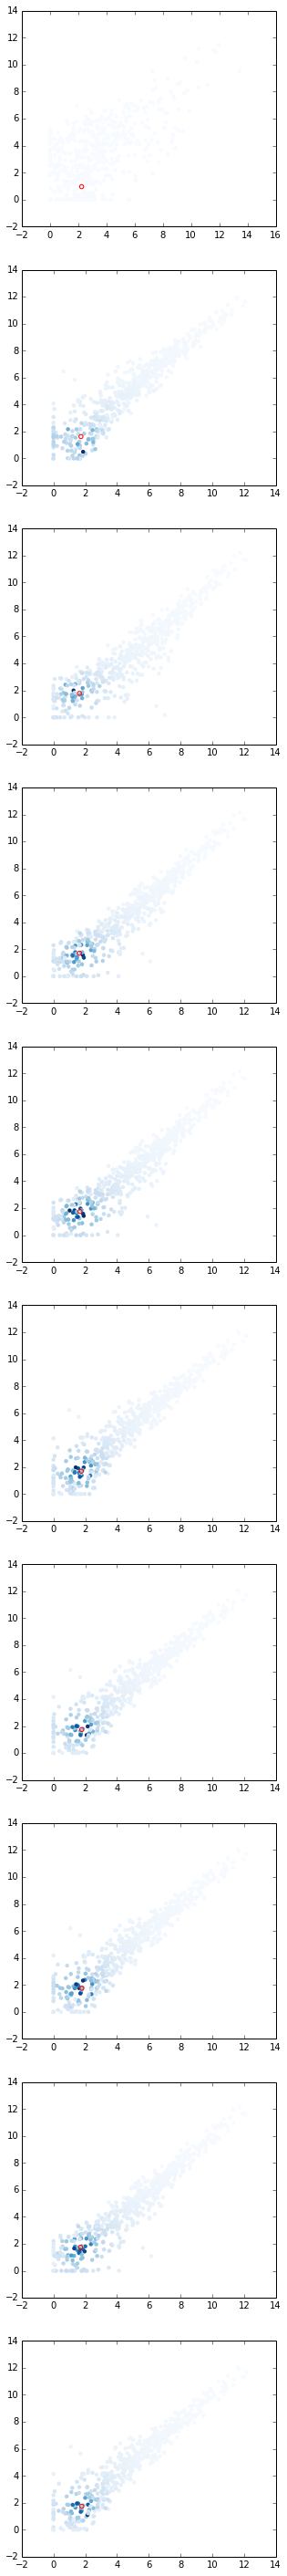

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline


fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(5, 50))

for iteration in range(0, num_iterations):
    X = H_history[0][iteration]
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
   
    weight = weight_matrices[0][iteration][:].mean(axis=1).mean(axis=1)
    axes[iteration].scatter(X[1:, x1], X[1:, x2], c=weight[1:], cmap='Blues', lw=0)
    axes[iteration].scatter(X[0, x1], X[0, x2], color='red', marker='o', facecolors='none')

In [70]:
out= {}

for i in range(test_size):
    out[i] = {}
    for iteration in range(num_iterations):
        print iteration
        out[i][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred[i][iteration][appliance]).loc[test_index[i]]
            print appliance
            try:
                if appliance=="hvac":
                    out[i][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
                else:   
                    out[i][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]
            except Exception, e:
                print (e)

0
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
1
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
2
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
3
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
oven
Found array with 0 sample(s) (shape=(0,)) while a mi

8
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
wm
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
oven
9
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
wm
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
oven
0
hvac
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
fridge
mw
dw
wm
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
1
hvac
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
fridge
mw
dw
wm
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
2
hvac
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
fridge
mw
dw
wm
oven
Found array with 0 sampl

fridge
mw
dw
wm
oven
1
hvac
fridge
mw
dw
wm
oven
2
hvac
fridge
mw
dw
wm
oven
3
hvac
fridge
mw
dw
wm
oven
4
hvac
fridge
mw
dw
wm
oven
5
hvac
fridge
mw
dw
wm
oven
6
hvac
fridge
mw
dw
wm
oven
7
hvac
fridge
mw
dw
wm
oven
8
hvac
fridge
mw
dw
wm
oven
9
hvac
fridge
mw
dw
wm
oven
0
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
1
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
2
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
3
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
4
hvac


no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt


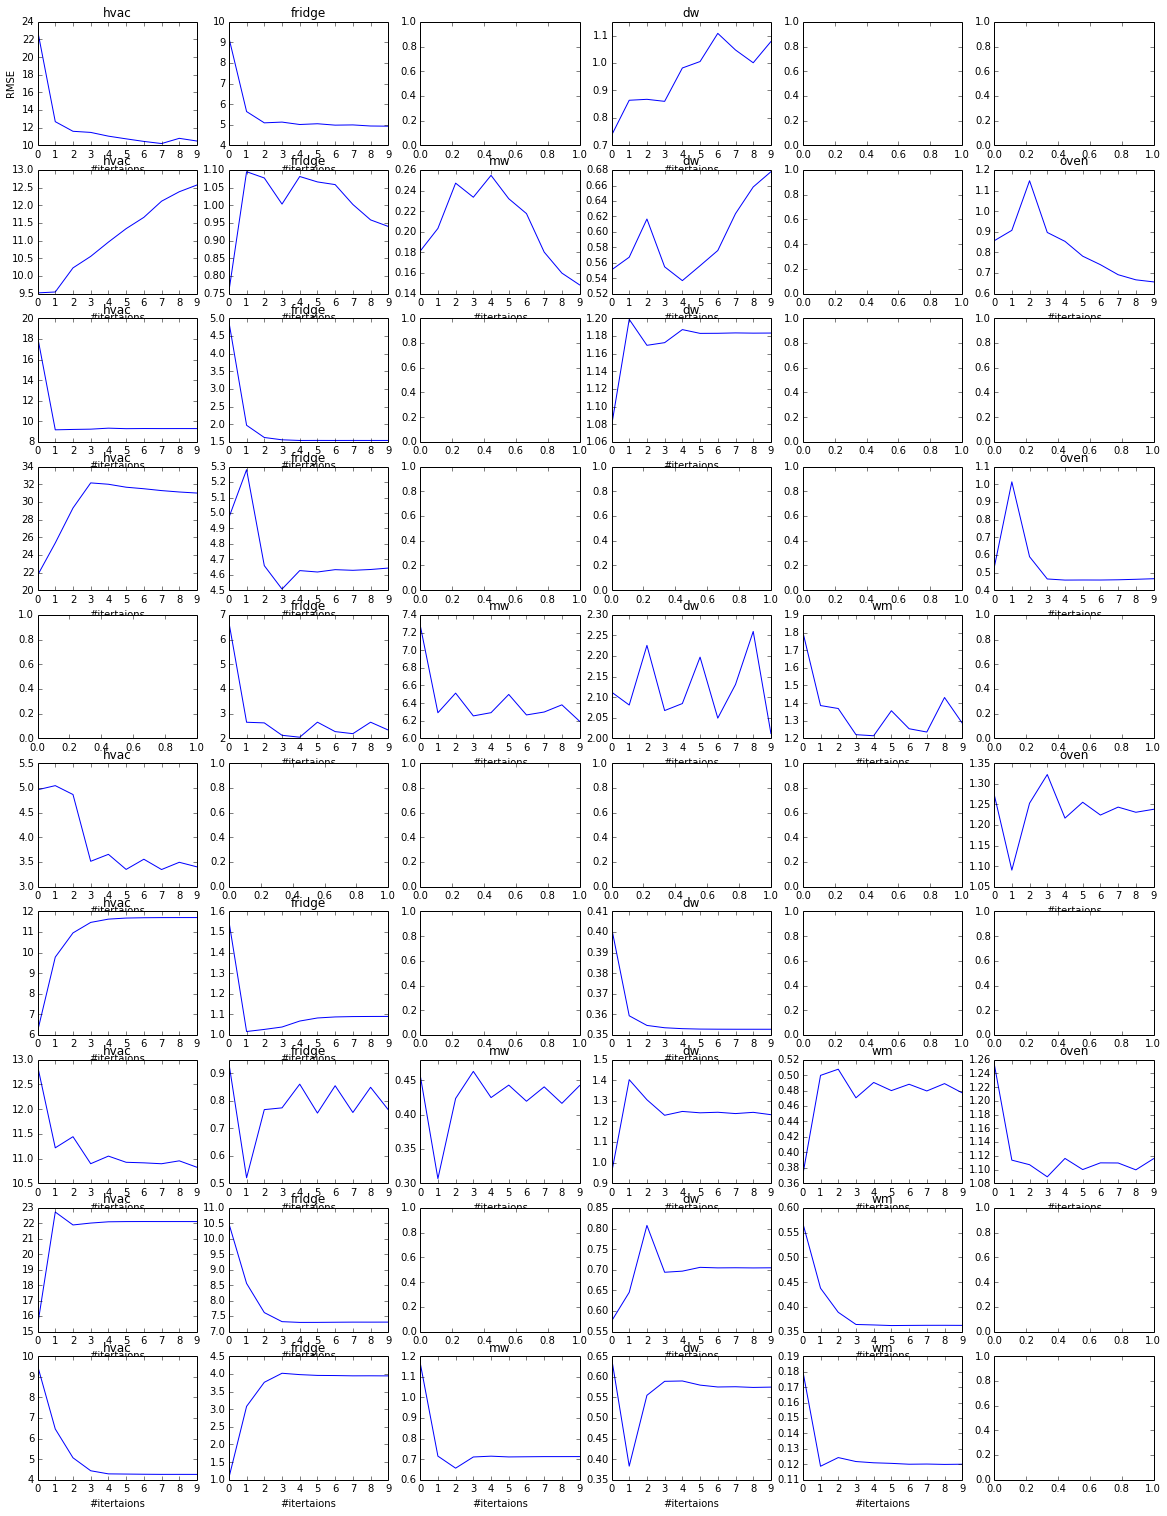

In [71]:
fig, axes = plt.subplots(nrows=test_size, ncols=6, figsize=(20, 30))
ax = axes.flatten()
count = 0

for i in range(test_size):
    mean_out = pd.DataFrame(out[i])
    for appliance in APPLIANCES_ORDER[1:]:
        try:
            mean_out.T[appliance].plot(ax = ax[count], title=appliance)

            ax[count].set_xlabel("#itertaions")
            count += 1
        except Exception, e:
            print "no gt"
            count += 1
ax[0].set_ylabel("RMSE")
# ax[count-1].legend(['with', 'without', 'app'], loc='center left')
# plt.suptitle("appliance RMSE for 6 test homes")
fig.subplots_adjust(top=0.8)
# plt.savefig("appliance-witherror-rmse.pdf", format='pdf')


In [73]:
out= {}

for iteration in range(num_iterations):
    print iteration
    out[iteration] = {}
    for appliance in APPLIANCES_ORDER[1:]:
        s = pd.concat(pred_test[iteration][appliance])
        print appliance
        try:
            if appliance=="hvac":
                out[iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
            else:   
                out[iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]
        except Exception, e:
            print (e)

0
hvac
fridge
mw
dw
wm
oven
1
hvac
fridge
mw
dw
wm
oven
2
hvac
fridge
mw
dw
wm
oven
3
hvac
fridge
mw
dw
wm
oven
4
hvac
fridge
mw
dw
wm
oven
5
hvac
fridge
mw
dw
wm
oven
6
hvac
fridge
mw
dw
wm
oven
7
hvac
fridge
mw
dw
wm
oven
8
hvac
fridge
mw
dw
wm
oven
9
hvac
fridge
mw
dw
wm
oven


In [57]:
out_sim = out

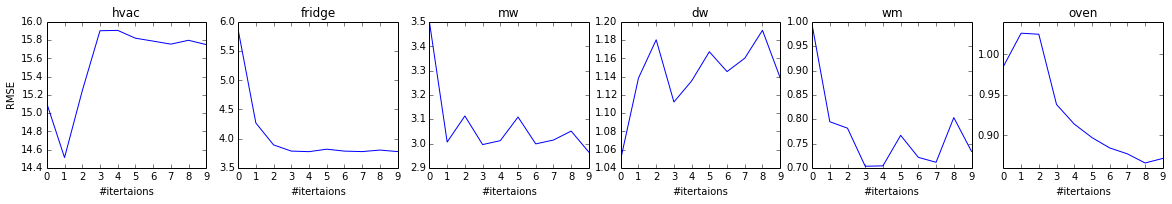

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 3))
ax = axes.flatten()
count = 0

mean_out = pd.DataFrame(out)
for appliance in APPLIANCES_ORDER[1:]:
    try:
        mean_out.T[appliance].plot(ax = ax[count], title=appliance)

        ax[count].set_xlabel("#itertaions")
        count += 1
    except Exception, e:
        print "no gt"
        count += 1
ax[0].set_ylabel("RMSE")
# ax[count-1].legend(['with', 'without', 'app'], loc='center left')
# plt.suptitle("appliance RMSE for 6 test homes")
fig.subplots_adjust(top=0.8)
# plt.savefig("appliance-10homes-sim.pdf", format='pdf')



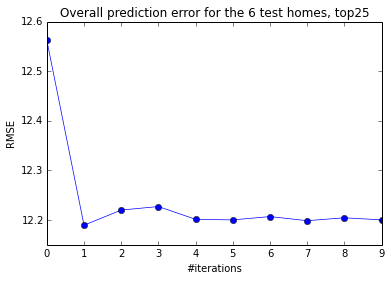

In [59]:
fig, ax = plt.subplots()
error = {}
error = (mean_out.T*pd.Series(contri['Austin'])).sum(axis=1)
error.plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])


ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 test homes, top25")

plt.savefig("overall-10homes-sim.pdf", format='pdf')